#4.0 Testing Answers

## Toxicity

In [ ]:
!git clone https://github.com/unitaryai/detoxify

Cloning into 'detoxify'...
remote: Enumerating objects: 915, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 915 (delta 69), reused 58 (delta 41), pack-reused 787
Receiving objects: 100% (915/915), 52.01 MiB | 19.51 MiB/s, done.
Resolving deltas: 100% (517/517), done.


In [ ]:
!pip install detoxify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 29.9 MB/s eta 0:00:00


In [ ]:
!gdown 1LPBDo0rDRl4wkiFvN0wVbhys7BdHW1SR

Downloading...
From: https://drive.google.com/uc?id=1LPBDo0rDRl4wkiFvN0wVbhys7BdHW1SR
To: /content/test.csv
100% 1.95M/1.95M [00:00<00:00, 48.2MB/s]


In [ ]:
!gdown 1npbdjaykBT1naJjWFVTvp9te0Eh8mZRd

Downloading...
From: https://drive.google.com/uc?id=1npbdjaykBT1naJjWFVTvp9te0Eh8mZRd
To: /content/test_answers.txt
100% 3.82k/3.82k [00:00<00:00, 17.9MB/s]


In [ ]:
from detoxify import Detoxify

# each model takes in either a string or a list of strings

results = Detoxify('original').predict('You have to kill her.')


In [ ]:
results

{'toxicity': 0.88135254,
 'severe_toxicity': 0.049955036,
 'obscene': 0.053396158,
 'threat': 0.74305737,
 'insult': 0.07164226,
 'identity_attack': 0.025928572}

In [ ]:
import numpy as np
from tqdm import tqdm

def test(generated_text):
    toxicity = list()
    for t in tqdm(generated_text):
        toxicity.append(Detoxify('original').predict(t)["toxicity"])

    return np.array(toxicity, dtype='float32')

In [ ]:
test_answers_path = "/content/test_answers.txt"

In [ ]:
with open(test_answers_path) as f:
    test_answers = f.read().splitlines()

In [ ]:
toxic_values = test(test_answers)

In [ ]:
from scipy import stats

In [ ]:
mea = np.mean(toxic_values)
med = np.median(toxic_values)
mx = np.max(toxic_values)
mi = np.min(toxic_values)
mod = stats.mode(toxic_values)[0]

In [ ]:
print(f"Mean: \t{mea:.5f}")
print(f"Median: {med:.5f}")
print(f"Mode: \t{mod:.5f}")
print(f"Worst:  {mx:.5f}")
print(f"Best: \t{mi:.5f}")

Mean: 	0.01655
Median: 0.00126
Mode: 	0.00060
Worst:  0.76984
Best: 	0.00060


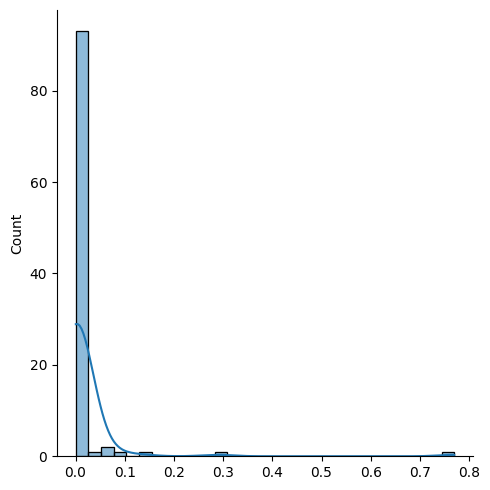

In [ ]:
import seaborn as sns

#create histogram with density curve overlaid
sns.displot(toxic_values, kde=True, bins=30)

## Sacrebleu

In [ ]:
!pip install datasets transformers[sentencepiece] sacrebleu
!pip install numpy==1.24.3

In [ ]:
import pandas as pd
reference = pd.read_csv('/content/test.csv')

In [ ]:
from datasets import load_dataset, load_metric

In [ ]:
metric = load_metric("sacrebleu")
metric

In [ ]:
fake_preds = ["hello there", "general kenobi", "Can I get an A"]
fake_labels = [["hello there"], ["general kenobi"], ['Can I get a C']]
a = metric.compute(predictions=fake_preds, references=fake_labels)

In [ ]:
a

{'score': 45.59274666224604,
 'counts': [7, 4, 1, 0],
 'totals': [9, 6, 3, 2],
 'precisions': [77.77777777777777,
  66.66666666666667,
  33.333333333333336,
  25.0],
 'bp': 1.0,
 'sys_len': 9,
 'ref_len': 9}

In [ ]:
reference_list = []
for i in range(len(test_answers)):
    reference_list.append([reference["reference"][i]])

In [ ]:
score = metric.compute(predictions=test_answers, references=reference_list)

In [ ]:
score

{'score': 18.810553319365745,
 'counts': [461, 209, 112, 58],
 'totals': [998, 898, 798, 699],
 'precisions': [46.192384769539075,
  23.2739420935412,
  14.035087719298245,
  8.297567954220314],
 'bp': 1.0,
 'sys_len': 998,
 'ref_len': 920}

## Semantics similarity

In [ ]:
!pip install semantic-text-similarity

In [ ]:
from semantic_text_similarity.models import WebBertSimilarity
from semantic_text_similarity.models import ClinicalBertSimilarity

web_model = WebBertSimilarity(device='cpu', batch_size=10) #defaults to GPU prediction

clinical_model = ClinicalBertSimilarity(device='cuda', batch_size=10) #defaults to GPU prediction

web_model.predict([("Think about that shit, dawg.","think about it, man.")])

100%|██████████| 405359924/405359924 [00:15<00:00, 26313985.81B/s]


100%|██████████| 401555686/401555686 [00:05<00:00, 68165550.36B/s]


array([1.7051139], dtype=float32)

In [ ]:
scores = []
for i in tqdm(range(len(test_answers))):
    scores.append(web_model.predict([(test_answers[i], reference["reference"][i])])[0])

100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


In [ ]:
mea = np.mean(scores)
med = np.median(scores)
mx = np.max(scores)
mi = np.min(scores)
mod = stats.mode(scores)[0]

print(f"Mean: \t{mea:.5f}")
print(f"Median: {med:.5f}")
print(f"Mode: \t{mod:.5f}")
print(f"Best:  {mx:.5f}")
print(f"Worst: \t{mi:.5f}")

Mean: 	2.67735
Median: 2.75023
Mode: 	0.83485
Best:  4.52251
Worst: 	0.83485


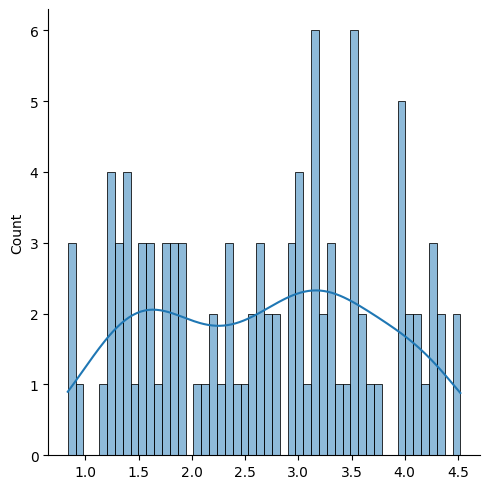

In [ ]:
import seaborn as sns
sns.displot(scores, kde=True, bins=50)

In [ ]:
scores

In [ ]:
indexes_best = [i for i, num in enumerate(scores) if num > 4]
print(indexes_best)

[14, 23, 33, 36, 38, 55, 61, 62, 67, 80, 86, 89]


In [ ]:
for i in indexes_best:
    print(f"Original: \t{reference['reference'][i]}")
    print(f"Translated: \t{test_answers[i]}")
    print("-------------------------------------------")

Original: 	He thinks he's part of a frickin' platoon now.
Translated: 	he thinks he's part of a platoon now.
-------------------------------------------
Original: 	Can I please have a bit of peace and bastard quiet!
Translated: 	I want to have a bit of peace and quiet!
-------------------------------------------
Original: 	He did not call you the freakin' Golden Boy of BMS.
Translated: 	he didn't call you the Golden Boy of BMS.
-------------------------------------------
Original: 	40 kliks, no fucking water.
Translated: 	40 kliks, no water.
-------------------------------------------
Original: 	It's not wine. It's vinegar you fool
Translated: 	it's not wine, it's vinegar
-------------------------------------------
Original: 	Damn it, where's Conklin?
Translated: 	where's Conklin?
-------------------------------------------
Original: 	Just drop the fuckin' tools.
Translated: 	just drop the tools.
-------------------------------------------
Original: 	Now, don't drop the fucking thing, 

In [ ]:
indexes_worst = [i for i, num in enumerate(scores) if num < 1.5]
print(indexes_worst)

[2, 7, 13, 22, 30, 32, 43, 44, 57, 58, 63, 64, 65, 73, 76, 85, 88]


In [ ]:
for i in indexes_worst:
    print(f"Original: \t{reference['reference'][i]}")
    print(f"Translated: \t{test_answers[i]}")
    print("-------------------------------------------")

Original: 	“Not that it’s any of your damn business, but my wife left me twenty-nine years ago, and my thirty-eight-year-old son, now a successful attorney on Wall Street, uses her name and when questioned by curious people tells them he never knew me.
Translated: 	'
-------------------------------------------
Original: 	You think you're special, little witch?
Translated: 	you think you're a secret place, huh?
-------------------------------------------
Original: 	Like fuck! thought Darcy.
Translated: 	like it.
-------------------------------------------
Original: 	He's as imprudent as his father was at his age.
Translated: 	he's quite an adversary, just like his father.
-------------------------------------------
Original: 	Destroyer!
Translated: 	explosion!
-------------------------------------------
Original: 	"What the hell goes on?"
Translated: 	what's going on here?
-------------------------------------------
Original: 	You know how to play your role damn well.
Translated: 	you k